# Practice 1: RNN Fundamentals - The Vanishing Gradient Problem

## SECTION 1: Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import time

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## SECTION 2: Data Loading and Preprocessing

In [8]:
print("Loading IMDB dataset...")

# TODO: Load the IMDB dataset
# Loading from the specified path
file_path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    raise

print(f"Dataset loaded: {len(df)} reviews")
print(f"Sentiment distribution:\n{df['sentiment'].value_counts()}")

# TODO: Convert sentiment labels to binary
# 'positive' -> 1, 'negative' -> 0
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# TODO: Use 30,000 samples
df = df[:30000]

# Simple text preprocessing
import re
from collections import Counter

def preprocess_text(text):
    """Basic text preprocessing"""
    text = text.lower()
    # TODO
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_text)

# Build vocabulary
print("Building vocabulary...")

# TODO: Tokenize reviews and build vocabulary
all_words = []
for review in df['cleaned_review']:
    all_words.extend(review.split())
    
# Count word frequencies to find most common words
counts = Counter(all_words)

# We keep the most common words to limit vocab size (e.g., top 25000 or all)
# The next lines in the notebook expect 'most_common' to be a list of (word, count)
most_common = counts.most_common()

# Create vocabulary with special tokens
word_to_idx = {'<PAD>': 0, '<UNK>': 1}
for idx, (word, count) in enumerate(most_common, start=2):
    word_to_idx[word] = idx

vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

# TODO: Tokenize and convert to indices
def text_to_indices(text, word_to_idx, max_len=None):
    """Convert text to sequence of indices"""
    words = text.split()
    indices = []
    
    for word in words:
        # Use <UNK> (index 1) if word is not in vocabulary
        indices.append(word_to_idx.get(word, 1))
    
    # Handle padding/truncation if max_len is provided
    if max_len is not None:
        if len(indices) > max_len:
            indices = indices[:max_len]
        else:
            # Pad with <PAD> (index 0)
            indices += [0] * (max_len - len(indices))
            
    return indices

# Split data: 80% train, 10% validation, 10% test
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Loading IMDB dataset...
Dataset loaded: 50000 reviews
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Building vocabulary...
Vocabulary size: 81847
Train: 24000, Val: 3000, Test: 3000


## SECTION 3: Dataset Class and DataLoaders

In [9]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = text_to_indices(text, self.word_to_idx, self.max_len)
        return torch.LongTensor(indices), torch.tensor(label, dtype=torch.float32)

# TODO
def create_dataloaders(train_df, val_df, test_df, word_to_idx, max_len, batch_size=32):
    """Create dataloaders for a specific sequence length"""
    # Create datasets
    train_dataset = IMDBDataset(
        train_df['cleaned_review'].values, 
        train_df['label'].values, 
        word_to_idx, 
        max_len
    )
    
    val_dataset = IMDBDataset(
        val_df['cleaned_review'].values, 
        val_df['label'].values, 
        word_to_idx, 
        max_len
    )
    
    test_dataset = IMDBDataset(
        test_df['cleaned_review'].values, 
        test_df['label'].values, 
        word_to_idx, 
        max_len
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


## SECTION 4: Model Definitions

In [13]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        super(SimpleRNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.hidden_dim = hidden_dim

        # Define Simple RNN layer
        # batch_first=True ensures input/output format is (batch, seq, feature)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # rnn_out: (batch_size, seq_len, hidden_dim)
        rnn_out, _ = self.rnn(embedded)

        # CRITICAL FIX: We must select ONLY the output of the last timestep
        # rnn_out[:, -1, :] extracts the last vector for each sample in the batch
        last_out = rnn_out[:, -1, :] 

        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out.squeeze()


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.hidden_dim = hidden_dim

        # Define LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)

        # lstm_out: (batch_size, seq_len, hidden_dim)
        lstm_out, (ht, ct) = self.lstm(embedded)

        # CRITICAL FIX: Select the last timestep
        last_out = lstm_out[:, -1, :]

        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out.squeeze()

## SECTION 5: Training and Evaluation Functions

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        # TODO
        data, target = data.to(device), target.to(device)

        # TODO: Complete the training steps
        optimizer.zero_grad()           # Clear gradients
        output = model(data)            # Forward pass
        loss = criterion(output, target) # Compute loss
        loss.backward()                 # Backward pass (compute gradients)
        optimizer.step()                # Update weights

        total_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    return total_loss / len(train_loader), 100. * correct / total


def evaluate(model, data_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            # TODO:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return total_loss / len(data_loader), 100. * correct / total


def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device):
    """Complete training loop"""
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs


## EXPERIMENT A: Sequence Length Impact Analysis


EXPERIMENT A: Sequence Length Impact Analysis

Training models with sequence length: 50

Training SimpleRNN (seq_len=50)...

Epoch 1/10


Training: 100%|██████████| 375/375 [00:03<00:00, 114.66it/s]


Train Loss: 0.6906, Train Acc: 54.19%
Val Loss: 0.6865, Val Acc: 56.13%

Epoch 2/10


Training: 100%|██████████| 375/375 [00:02<00:00, 132.68it/s]


Train Loss: 0.6780, Train Acc: 57.34%
Val Loss: 0.6918, Val Acc: 54.37%

Epoch 3/10


Training: 100%|██████████| 375/375 [00:02<00:00, 133.33it/s]


Train Loss: 0.6592, Train Acc: 61.14%
Val Loss: 0.7096, Val Acc: 59.10%

Epoch 4/10


Training: 100%|██████████| 375/375 [00:02<00:00, 131.98it/s]


Train Loss: 0.6077, Train Acc: 67.21%
Val Loss: 0.6829, Val Acc: 61.33%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:02<00:00, 132.23it/s]


Train Loss: 0.5928, Train Acc: 68.53%
Val Loss: 0.7232, Val Acc: 59.83%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:02<00:00, 133.23it/s]


Train Loss: 0.5301, Train Acc: 74.17%
Val Loss: 0.7267, Val Acc: 54.73%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:02<00:00, 131.60it/s]


Train Loss: 0.5386, Train Acc: 72.83%
Val Loss: 0.6976, Val Acc: 65.37%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:02<00:00, 132.80it/s]


Train Loss: 0.4353, Train Acc: 80.77%
Val Loss: 0.7400, Val Acc: 65.20%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:02<00:00, 133.50it/s]


Train Loss: 0.3806, Train Acc: 83.53%
Val Loss: 0.7431, Val Acc: 65.80%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:02<00:00, 131.99it/s]


Train Loss: 0.3863, Train Acc: 82.94%
Val Loss: 0.7796, Val Acc: 64.13%
SimpleRNN Test Accuracy: 63.03%
Training time: 30.85s

Training LSTM (seq_len=50)...

Epoch 1/10


Training: 100%|██████████| 375/375 [00:03<00:00, 118.52it/s]


Train Loss: 0.6645, Train Acc: 59.09%
Val Loss: 0.6152, Val Acc: 68.10%

Epoch 2/10


Training: 100%|██████████| 375/375 [00:03<00:00, 120.04it/s]


Train Loss: 0.5515, Train Acc: 72.80%
Val Loss: 0.5640, Val Acc: 71.70%

Epoch 3/10


Training: 100%|██████████| 375/375 [00:03<00:00, 117.71it/s]


Train Loss: 0.4409, Train Acc: 80.08%
Val Loss: 0.5079, Val Acc: 75.13%

Epoch 4/10


Training: 100%|██████████| 375/375 [00:03<00:00, 119.42it/s]


Train Loss: 0.3468, Train Acc: 85.34%
Val Loss: 0.5175, Val Acc: 75.23%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:03<00:00, 119.41it/s]


Train Loss: 0.2633, Train Acc: 89.70%
Val Loss: 0.5845, Val Acc: 74.57%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:03<00:00, 118.57it/s]


Train Loss: 0.1904, Train Acc: 92.91%
Val Loss: 0.6791, Val Acc: 77.47%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:03<00:00, 119.22it/s]


Train Loss: 0.1326, Train Acc: 95.34%
Val Loss: 0.7705, Val Acc: 75.53%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:03<00:00, 118.76it/s]


Train Loss: 0.0879, Train Acc: 97.15%
Val Loss: 0.8073, Val Acc: 75.70%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:03<00:00, 119.53it/s]


Train Loss: 0.0550, Train Acc: 98.44%
Val Loss: 1.0235, Val Acc: 77.53%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:03<00:00, 119.82it/s]


Train Loss: 0.0416, Train Acc: 98.76%
Val Loss: 1.0943, Val Acc: 76.40%
LSTM Test Accuracy: 76.50%
Training time: 33.84s

Training models with sequence length: 100

Training SimpleRNN (seq_len=100)...

Epoch 1/10


Training: 100%|██████████| 375/375 [00:02<00:00, 126.20it/s]


Train Loss: 0.6977, Train Acc: 51.05%
Val Loss: 0.6938, Val Acc: 51.17%

Epoch 2/10


Training: 100%|██████████| 375/375 [00:02<00:00, 126.47it/s]


Train Loss: 0.6841, Train Acc: 55.29%
Val Loss: 0.6955, Val Acc: 54.43%

Epoch 3/10


Training: 100%|██████████| 375/375 [00:02<00:00, 128.44it/s]


Train Loss: 0.6762, Train Acc: 57.05%
Val Loss: 0.6960, Val Acc: 52.07%

Epoch 4/10


Training: 100%|██████████| 375/375 [00:02<00:00, 126.13it/s]


Train Loss: 0.6567, Train Acc: 60.55%
Val Loss: 0.7061, Val Acc: 54.53%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:03<00:00, 123.58it/s]


Train Loss: 0.6270, Train Acc: 64.41%
Val Loss: 0.7173, Val Acc: 53.77%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:03<00:00, 123.66it/s]


Train Loss: 0.5927, Train Acc: 67.88%
Val Loss: 0.7232, Val Acc: 51.83%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:02<00:00, 125.41it/s]


Train Loss: 0.5669, Train Acc: 69.87%
Val Loss: 0.7682, Val Acc: 56.97%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:02<00:00, 125.16it/s]


Train Loss: 0.5219, Train Acc: 73.96%
Val Loss: 0.8610, Val Acc: 50.37%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:03<00:00, 124.47it/s]


Train Loss: 0.4926, Train Acc: 75.48%
Val Loss: 0.8060, Val Acc: 60.27%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:03<00:00, 124.84it/s]


Train Loss: 0.4729, Train Acc: 76.84%
Val Loss: 0.8063, Val Acc: 57.60%
SimpleRNN Test Accuracy: 58.23%
Training time: 32.17s

Training LSTM (seq_len=100)...

Epoch 1/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.39it/s]


Train Loss: 0.6791, Train Acc: 56.42%
Val Loss: 0.6335, Val Acc: 64.63%

Epoch 2/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.59it/s]


Train Loss: 0.6611, Train Acc: 60.02%
Val Loss: 0.6287, Val Acc: 65.90%

Epoch 3/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.66it/s]


Train Loss: 0.5041, Train Acc: 75.40%
Val Loss: 0.4755, Val Acc: 77.67%

Epoch 4/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.07it/s]


Train Loss: 0.3360, Train Acc: 85.80%
Val Loss: 0.4040, Val Acc: 82.60%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:03<00:00, 97.12it/s]


Train Loss: 0.2335, Train Acc: 91.12%
Val Loss: 0.4171, Val Acc: 82.70%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.12it/s]


Train Loss: 0.1552, Train Acc: 94.55%
Val Loss: 0.4640, Val Acc: 82.60%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:03<00:00, 95.90it/s]


Train Loss: 0.0964, Train Acc: 97.03%
Val Loss: 0.5282, Val Acc: 82.50%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:03<00:00, 96.81it/s]


Train Loss: 0.0569, Train Acc: 98.35%
Val Loss: 0.6564, Val Acc: 82.17%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:03<00:00, 97.16it/s]


Train Loss: 0.0400, Train Acc: 98.92%
Val Loss: 0.6959, Val Acc: 81.60%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:04<00:00, 92.90it/s]


Train Loss: 0.6928, Train Acc: 51.05%
Val Loss: 0.7000, Val Acc: 49.93%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:04<00:00, 90.98it/s]


Train Loss: 0.6906, Train Acc: 51.57%
Val Loss: 0.6944, Val Acc: 48.57%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:04<00:00, 90.54it/s]


Train Loss: 0.6880, Train Acc: 52.37%
Val Loss: 0.6976, Val Acc: 49.60%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:04<00:00, 90.36it/s]


Train Loss: 0.6856, Train Acc: 51.83%
Val Loss: 0.6992, Val Acc: 49.83%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:04<00:00, 92.15it/s]


Train Loss: 0.6791, Train Acc: 52.38%
Val Loss: 0.6946, Val Acc: 50.40%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:04<00:00, 91.96it/s]


Train Loss: 0.6786, Train Acc: 53.14%
Val Loss: 0.7096, Val Acc: 49.70%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:04<00:00, 92.90it/s]


Train Loss: 0.6656, Train Acc: 53.87%
Val Loss: 0.7183, Val Acc: 48.23%
SimpleRNN Test Accuracy: 49.97%
Training time: 43.92s

Training LSTM (seq_len=400)...

Epoch 1/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.33it/s]


Train Loss: 0.6931, Train Acc: 50.48%
Val Loss: 0.6914, Val Acc: 49.10%

Epoch 2/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.29it/s]


Train Loss: 0.6848, Train Acc: 53.13%
Val Loss: 0.6948, Val Acc: 52.37%

Epoch 3/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.37it/s]


Train Loss: 0.6659, Train Acc: 54.47%
Val Loss: 0.7067, Val Acc: 49.23%

Epoch 4/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.60it/s]


Train Loss: 0.6330, Train Acc: 55.68%
Val Loss: 0.7370, Val Acc: 52.57%

Epoch 5/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.71it/s]


Train Loss: 0.6088, Train Acc: 57.25%
Val Loss: 0.7966, Val Acc: 48.77%

Epoch 6/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.06it/s]


Train Loss: 0.6005, Train Acc: 57.32%
Val Loss: 0.8276, Val Acc: 48.80%

Epoch 7/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.52it/s]


Train Loss: 0.5984, Train Acc: 57.15%
Val Loss: 0.8327, Val Acc: 52.30%

Epoch 8/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.32it/s]


Train Loss: 0.6065, Train Acc: 57.05%
Val Loss: 0.7792, Val Acc: 52.53%

Epoch 9/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.56it/s]


Train Loss: 0.5990, Train Acc: 57.48%
Val Loss: 0.8204, Val Acc: 48.67%

Epoch 10/10


Training: 100%|██████████| 375/375 [00:08<00:00, 46.58it/s]


Train Loss: 0.5944, Train Acc: 57.79%
Val Loss: 0.8407, Val Acc: 48.90%
LSTM Test Accuracy: 50.53%
Training time: 85.85s


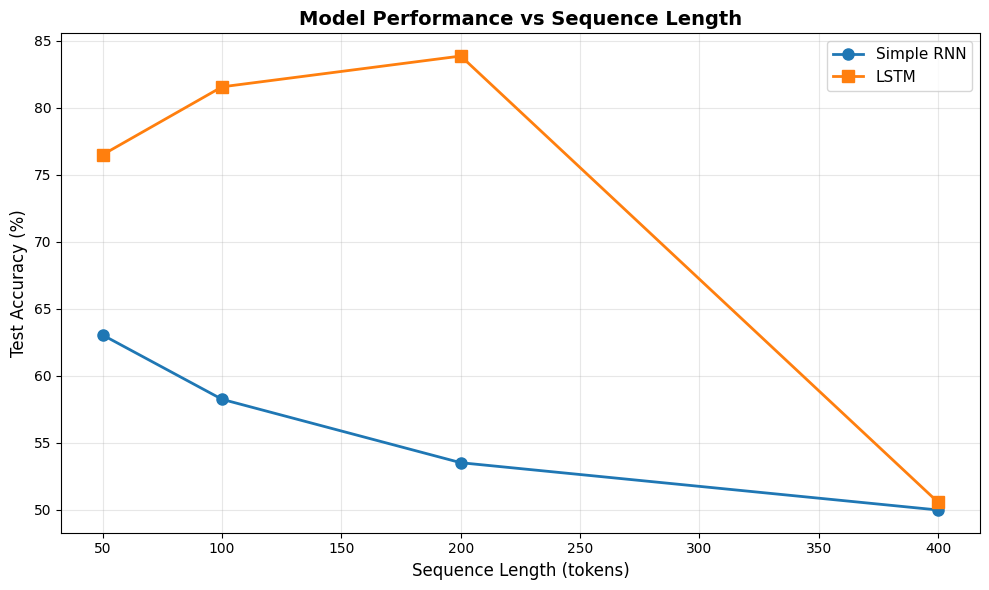


Results Summary:
------------------------------------------------------------
Seq Length      SimpleRNN Acc        LSTM Acc            
------------------------------------------------------------
50              63.03                76.50               
100             58.23                81.57               
200             53.50                83.87               
400             49.97                50.53               


In [15]:
print("\n" + "="*80)
print("EXPERIMENT A: Sequence Length Impact Analysis")
print("="*80)

# Sequence lengths to test
sequence_lengths = [50, 100, 200, 400]
results = {
    'sequence_length': [],
    'simple_rnn_acc': [],
    'lstm_acc': []
}

# Hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Train models for each sequence length
for seq_len in sequence_lengths:
    print(f"\n{'='*80}")
    print(f"Training models with sequence length: {seq_len}")
    print(f"{'='*80}")

    # TODO: Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        train_df, val_df, test_df, word_to_idx, seq_len, BATCH_SIZE
    )

    # TODO: Train SimpleRNN
    print(f"\nTraining SimpleRNN (seq_len={seq_len})...")
    simple_rnn = SimpleRNNClassifier(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(simple_rnn.parameters(), lr=LEARNING_RATE)

    start_time = time.time()
    # Using the train_model function defined in Section 5
    train_model(simple_rnn, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)
    rnn_train_time = time.time() - start_time

    # TODO: Evaluate SimpleRNN on test set
    _, rnn_test_acc = evaluate(simple_rnn, test_loader, criterion, device)
    print(f"SimpleRNN Test Accuracy: {rnn_test_acc:.2f}%")
    print(f"Training time: {rnn_train_time:.2f}s")

    # TODO: Train LSTM
    print(f"\nTraining LSTM (seq_len={seq_len})...")
    lstm_model = LSTMClassifier(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()
    train_model(lstm_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)
    lstm_train_time = time.time() - start_time

    # TODO: Evaluate LSTM on test set
    _, lstm_test_acc = evaluate(lstm_model, test_loader, criterion, device)
    print(f"LSTM Test Accuracy: {lstm_test_acc:.2f}%")
    print(f"Training time: {lstm_train_time:.2f}s")

    # Store results
    results['sequence_length'].append(seq_len)
    results['simple_rnn_acc'].append(rnn_test_acc)
    results['lstm_acc'].append(lstm_test_acc)

# Create visualization
plt.figure(figsize=(10, 6))
plt.plot(results['sequence_length'], results['simple_rnn_acc'],
         marker='o', linewidth=2, markersize=8, label='Simple RNN')
plt.plot(results['sequence_length'], results['lstm_acc'],
         marker='s', linewidth=2, markersize=8, label='LSTM')
plt.xlabel('Sequence Length (tokens)', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Model Performance vs Sequence Length', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('experiment_a_accuracy_vs_length.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results table
print("\nResults Summary:")
print("-" * 60)
print(f"{'Seq Length':<15} {'SimpleRNN Acc':<20} {'LSTM Acc':<20}")
print("-" * 60)
for i in range(len(results['sequence_length'])):
    print(f"{results['sequence_length'][i]:<15} {results['simple_rnn_acc'][i]:<20.2f} {results['lstm_acc'][i]:<20.2f}")


## EXPERIMENT B: Gradient Flow Measurement


EXPERIMENT B: Gradient Flow Measurement
Training SimpleRNN for gradient analysis...

Epoch 1/3


Training: 100%|██████████| 375/375 [00:03<00:00, 110.66it/s]


Train Loss: 0.6963, Train Acc: 50.70%
Val Loss: 0.6962, Val Acc: 48.40%

Epoch 2/3


Training: 100%|██████████| 375/375 [00:03<00:00, 111.21it/s]


Train Loss: 0.6876, Train Acc: 52.48%
Val Loss: 0.6977, Val Acc: 48.17%

Epoch 3/3


Training: 100%|██████████| 375/375 [00:03<00:00, 112.03it/s]


Train Loss: 0.6865, Train Acc: 53.48%
Val Loss: 0.7092, Val Acc: 48.07%

Training LSTM for gradient analysis...

Epoch 1/3


Training: 100%|██████████| 375/375 [00:05<00:00, 71.17it/s]


Train Loss: 0.6916, Train Acc: 51.93%
Val Loss: 0.6817, Val Acc: 57.33%

Epoch 2/3


Training: 100%|██████████| 375/375 [00:05<00:00, 71.41it/s]


Train Loss: 0.6854, Train Acc: 54.37%
Val Loss: 0.6904, Val Acc: 53.93%

Epoch 3/3


Training: 100%|██████████| 375/375 [00:05<00:00, 71.32it/s]


Train Loss: 0.6773, Train Acc: 57.10%
Val Loss: 0.6676, Val Acc: 65.10%

Capturing gradients for SimpleRNN...
Capturing gradients for LSTM...


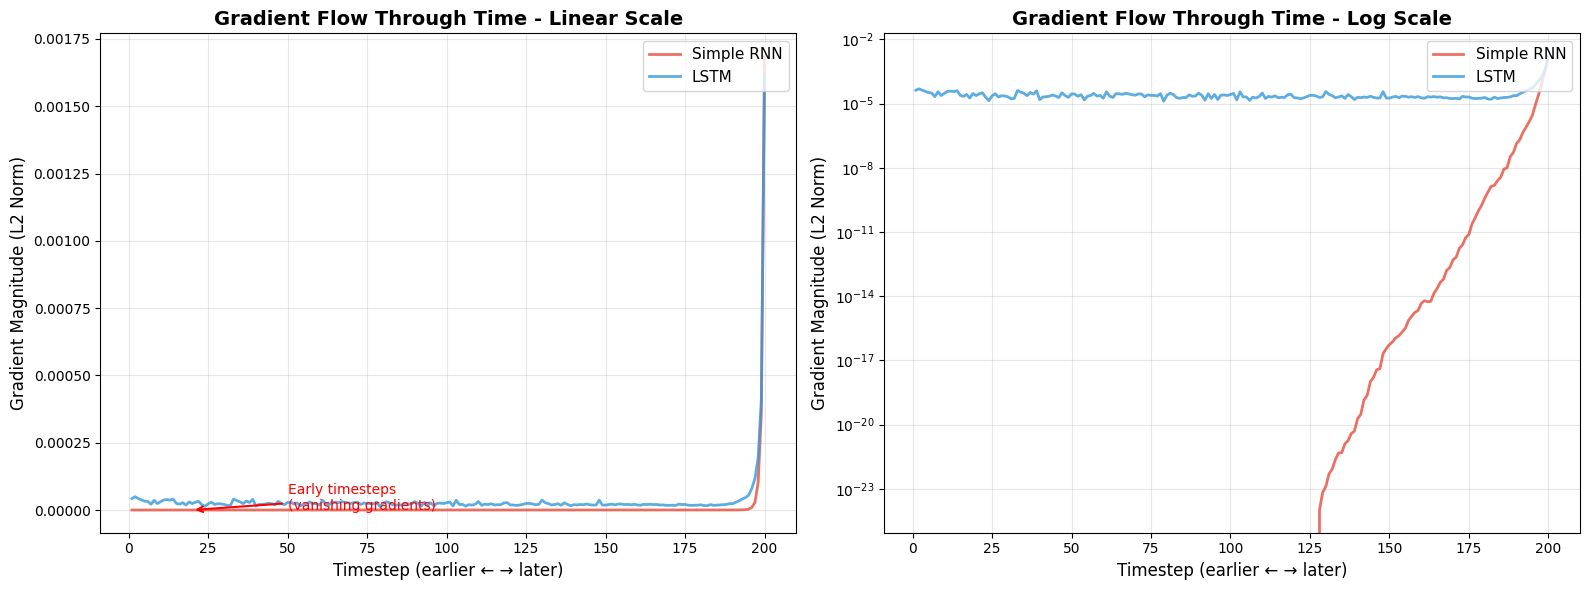


GRADIENT FLOW ANALYSIS

1. GRADIENT MAGNITUDES AT KEY TIMESTEPS:
   Timestep        SimpleRNN            LSTM                
   -------------------------------------------------------
   t=10            0.00000000           0.00003045          
   t=100           0.00000000           0.00002700          
   t=190           0.00000014           0.00002357          

2. GRADIENT DECAY (Early timestep / Late timestep):
   SimpleRNN: 0.000000x  (SEVERE VANISHING)
   LSTM:      1.292088x  (Good gradient flow)


In [16]:
print("\n" + "="*80)
print("EXPERIMENT B: Gradient Flow Measurement")
print("="*80)

# We'll use sequence length 200 for this experiment
SEQ_LEN = 200
BATCH_SIZE = 64
LR = 0.001
EPOCHS_GRAD = 3 # Reduced epochs for speed, sufficient for gradient analysis

# TODO: Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_df, val_df, test_df, word_to_idx, SEQ_LEN, BATCH_SIZE
)

# TODO: Initialize fresh models
rnn_model = SimpleRNNClassifier(vocab_size, 128, 128).to(device)
lstm_model = LSTMClassifier(vocab_size, 128, 128).to(device)

criterion = nn.BCELoss()

# TODO: Train models
print("Training SimpleRNN for gradient analysis...")
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=LR)
train_model(rnn_model, train_loader, val_loader, criterion, optimizer_rnn, EPOCHS_GRAD, device)

print("\nTraining LSTM for gradient analysis...")
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=LR)
train_model(lstm_model, train_loader, val_loader, criterion, optimizer_lstm, EPOCHS_GRAD, device)

# Measure gradients w.r.t. embeddings at each timestep
def measure_gradient_flow(model, data, target, seq_len):
    """
    Measure gradient magnitude at each timestep by computing gradients
    with respect to the embedding at each position.

    This properly captures the vanishing gradient problem by showing
    how gradient signal decays as it propagates backwards through time.
    """
    model.train()
    data = data.to(device)
    target = target.to(device)

    # Get embeddings with gradient tracking
    embedded = model.embedding(data)  # (batch_size, seq_len, embedding_dim)
    embedded.retain_grad()  # Important: retain gradients for intermediate tensor

    # TODO: Forward pass through RNN/LSTM
    # Check if model has 'rnn' or 'lstm' attribute
    if hasattr(model, 'rnn'):
        out_seq, _ = model.rnn(embedded)
    else:
        out_seq, _ = model.lstm(embedded)

    # TODO: Use last timestep for prediction (as in original model)
    last_output = out_seq[:, -1, :]
    
    out = model.fc(last_output)
    out = model.sigmoid(out).squeeze()

    # TODO: Compute loss
    loss = criterion(out, target)

    # TODO: Backward pass
    loss.backward()

    # Extract gradients at each timestep position
    if embedded.grad is not None:
        # TODO: Compute L2 norm at each timestep
        # embedded.grad shape: (batch_size, seq_len, embedding_dim)
        # We calculate norm over embedding_dim (dim=2), then average over batch (dim=0)
        grad_norms = embedded.grad.norm(2, dim=2).mean(dim=0).cpu().numpy()
        return grad_norms
    else:
        return np.zeros(seq_len)

# Get a batch from validation set
val_iter = iter(val_loader)
data_batch, target_batch = next(val_iter)

# TODO
print("\nCapturing gradients for SimpleRNN...")
rnn_grads = measure_gradient_flow(rnn_model, data_batch, target_batch, SEQ_LEN)

# TODO
print("Capturing gradients for LSTM...")
lstm_grads = measure_gradient_flow(lstm_model, data_batch, target_batch, SEQ_LEN)

# VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Linear scale
ax1 = axes[0]
timesteps = np.arange(1, SEQ_LEN + 1)

ax1.plot(timesteps, rnn_grads, linewidth=2, label='Simple RNN', alpha=0.8, color='#e74c3c')
ax1.plot(timesteps, lstm_grads, linewidth=2, label='LSTM', alpha=0.8, color='#3498db')

ax1.set_xlabel('Timestep (earlier ← → later)', fontsize=12)
ax1.set_ylabel('Gradient Magnitude (L2 Norm)', fontsize=12)
ax1.set_title('Gradient Flow Through Time - Linear Scale', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# Add annotation pointing to early timesteps
ax1.annotate('Early timesteps\n(vanishing gradients)',
             xy=(20, rnn_grads[19]), xytext=(50, rnn_grads[19] * 3),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red')

# Plot 2: Log scale (better for seeing vanishing gradients)
ax2 = axes[1]

ax2.plot(timesteps, rnn_grads, linewidth=2, label='Simple RNN', alpha=0.8, color='#e74c3c')
ax2.plot(timesteps, lstm_grads, linewidth=2, label='LSTM', alpha=0.8, color='#3498db')

ax2.set_xlabel('Timestep (earlier ← → later)', fontsize=12)
ax2.set_ylabel('Gradient Magnitude (L2 Norm)', fontsize=12)
ax2.set_title('Gradient Flow Through Time - Log Scale', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('experiment_b_gradient_flow_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

# ANALYSIS AND STATISTICS
print("\n" + "="*80)
print("GRADIENT FLOW ANALYSIS")
print("="*80)

# Calculate gradient decay ratios at different points
early_timestep = 10
mid_timestep = 100
late_timestep = 190

print(f"\n1. GRADIENT MAGNITUDES AT KEY TIMESTEPS:")
print(f"   {'Timestep':<15} {'SimpleRNN':<20} {'LSTM':<20}")
print(f"   {'-'*55}")
print(f"   {f't={early_timestep}':<15} {rnn_grads[early_timestep-1]:<20.8f} {lstm_grads[early_timestep-1]:<20.8f}")
print(f"   {f't={mid_timestep}':<15} {rnn_grads[mid_timestep-1]:<20.8f} {lstm_grads[mid_timestep-1]:<20.8f}")
print(f"   {f't={late_timestep}':<15} {rnn_grads[late_timestep-1]:<20.8f} {lstm_grads[late_timestep-1]:<20.8f}")

# Calculate decay ratios
rnn_early_to_late = rnn_grads[early_timestep-1] / rnn_grads[late_timestep-1]
lstm_early_to_late = lstm_grads[early_timestep-1] / lstm_grads[late_timestep-1]

print(f"\n2. GRADIENT DECAY (Early timestep / Late timestep):")
print(f"   SimpleRNN: {rnn_early_to_late:.6f}x  ({'SEVERE VANISHING' if rnn_early_to_late < 0.01 else 'Moderate vanishing'})")
print(f"   LSTM:      {lstm_early_to_late:.6f}x  ({'Good gradient flow' if lstm_early_to_late > 0.1 else 'Some vanishing'})")

## EXPERIMENT C: Hidden State Dynamics Analysis


EXPERIMENT C: Hidden State Dynamics Analysis
Selected 10 test sequences for analysis
Positive samples indices: [27013, 27014, 27016, 27019, 27022]
Negative samples indices: [27000, 27002, 27007, 27008, 27010]
Extracting hidden states from SimpleRNN...
Extracting hidden states from LSTM...


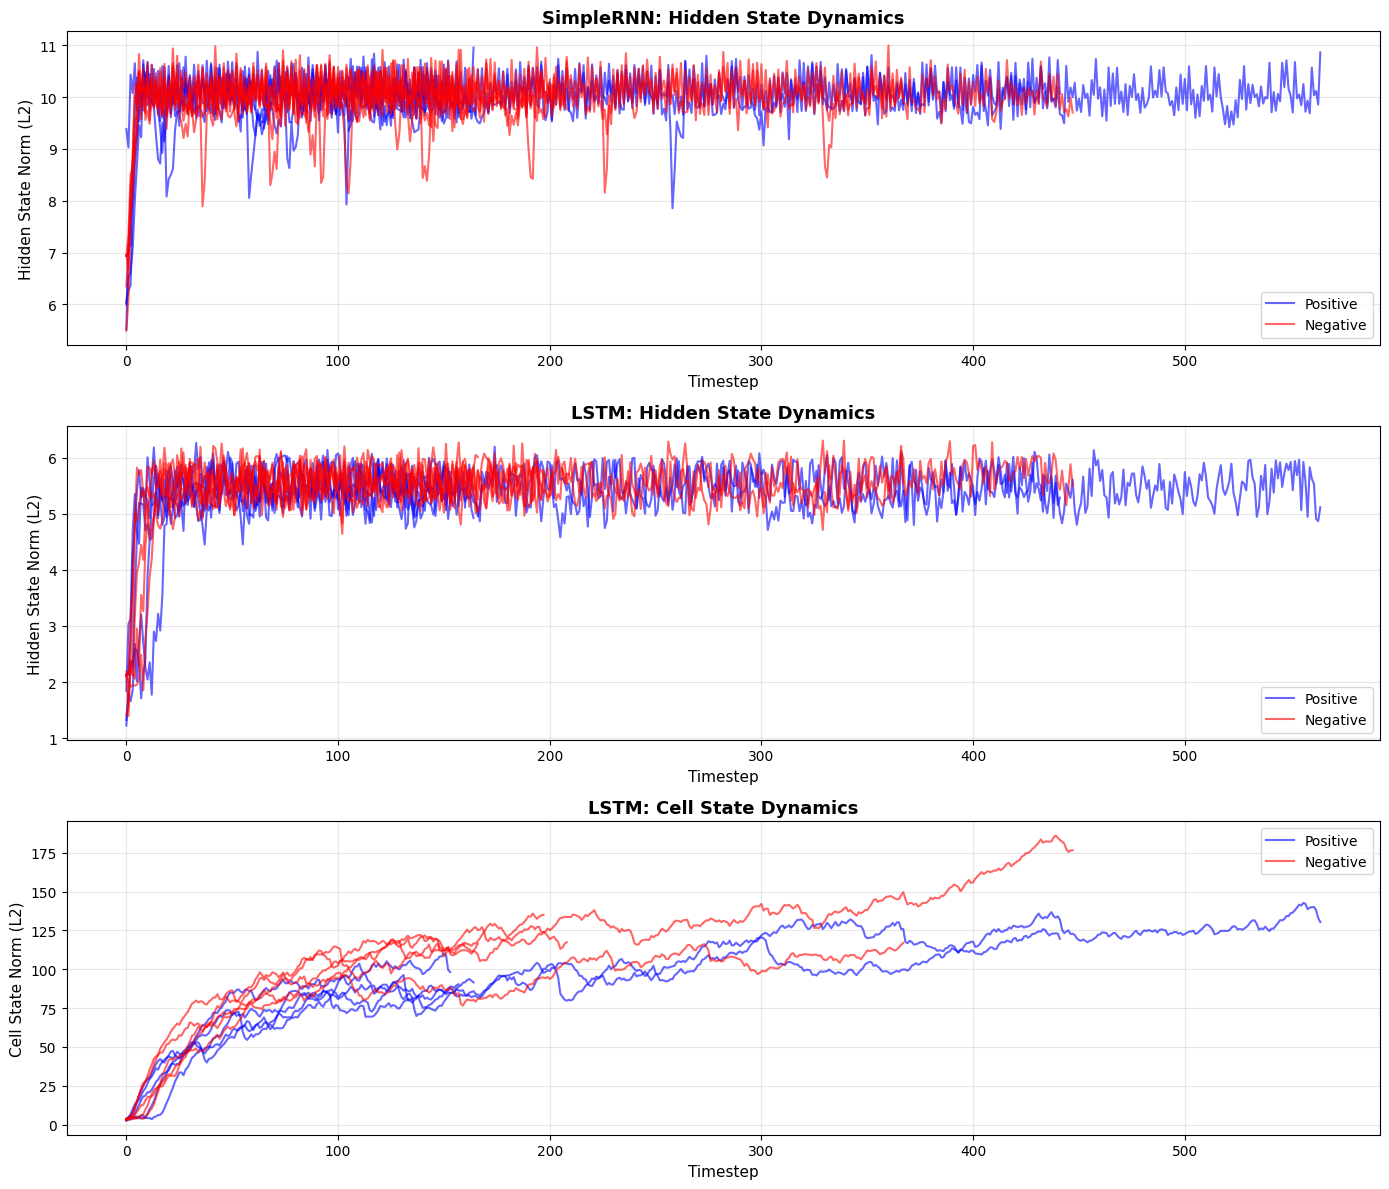


 Hidden State Statistics:
------------------------------------------------------------
SimpleRNN hidden state variance: Mean=0.2973, Std=0.1190
LSTM hidden state variance:      Mean=0.4096, Std=0.2606
LSTM cell state variance:        Mean=838.4113, Std=256.8120


In [17]:
print("\n" + "="*80)
print("EXPERIMENT C: Hidden State Dynamics Analysis")
print("="*80)

# TODO: Select test sequences (5 positive, 5 negative, all at least 150 tokens)
# Filter test data for sequences >= 150 words
test_df['length'] = test_df['cleaned_review'].apply(lambda x: len(x.split()))
long_reviews = test_df[test_df['length'] >= 150]

positive_samples = long_reviews[long_reviews['label'] == 1].head(5)
negative_samples = long_reviews[long_reviews['label'] == 0].head(5)

test_samples = pd.concat([positive_samples, negative_samples])

print(f"Selected {len(test_samples)} test sequences for analysis")
print(f"Positive samples indices: {positive_samples.index.tolist()}")
print(f"Negative samples indices: {negative_samples.index.tolist()}")

# Extract hidden states during inference
def extract_hidden_states(model, texts, labels, word_to_idx, model_type='rnn'):
    """Extract hidden states at each timestep"""
    model.eval()

    all_hidden_norms = []
    all_cell_norms = []
    all_labels = []

    with torch.no_grad():
        for text, label in zip(texts, labels):
            # TODO: Convert text to indices (don't pad, use natural length)
            indices = text_to_indices(text, word_to_idx) # No max_len implies natural length
            x = torch.LongTensor([indices]).to(device)

            # TODO: Get embeddings
            embedded = model.embedding(x)
            
            if model_type == 'rnn':
                # For RNN, output IS the sequence of hidden states
                hidden_states, _ = model.rnn(embedded)
                hidden_states = hidden_states.squeeze(0).cpu().numpy()
                cell_states = None
                
            else:  # lstm
                # To get all cell states, we need to process step by step
                all_h = []
                all_c = []
                
                # TODO: Initialize with correct number of layers
                batch_size = x.size(0)
                # h_0, c_0: (num_layers, batch, hidden_dim)
                h_t = torch.zeros(1, batch_size, model.hidden_dim).to(device)
                c_t = torch.zeros(1, batch_size, model.hidden_dim).to(device)

                for t in range(embedded.size(1)):
                    # Feed one timestep at a time: (batch, 1, embed_dim)
                    input_t = embedded[:, t:t+1, :]
                    out, (h_t, c_t) = model.lstm(input_t, (h_t, c_t))
                    
                    all_h.append(h_t.squeeze().cpu().numpy())
                    # TODO: Store only the last layer's cell state
                    all_c.append(c_t.squeeze().cpu().numpy())

                hidden_states = np.array(all_h)
                cell_states = np.array(all_c)

            # TODO: Compute L2 norms at each timestep
            # hidden_states shape: (seq_len, hidden_dim)
            hidden_norms = np.linalg.norm(hidden_states, axis=1)
            all_hidden_norms.append(hidden_norms)

            if cell_states is not None:
                cell_norms = np.linalg.norm(cell_states, axis=1)
                all_cell_norms.append(cell_norms)

            all_labels.append(label)

    return all_hidden_norms, all_cell_norms, all_labels

# TODO
print("Extracting hidden states from SimpleRNN...")
rnn_hidden_norms, _, rnn_labels = extract_hidden_states(
    rnn_model, test_samples['cleaned_review'], test_samples['label'], word_to_idx, model_type='rnn'
)

# TODO
print("Extracting hidden states from LSTM...")
lstm_hidden_norms, lstm_cell_norms, lstm_labels = extract_hidden_states(
    lstm_model, test_samples['cleaned_review'], test_samples['label'], word_to_idx, model_type='lstm'
)

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: SimpleRNN Hidden States
ax1 = axes[0]
for i, (norms, label) in enumerate(zip(rnn_hidden_norms, rnn_labels)):
    color = 'blue' if label == 1 else 'red'
    label_text = 'Positive' if label == 1 else 'Negative'
    # Use distinct label for legend only once
    lbl = label_text if (i == 0 or i == 5) else "" 
    # Fix legend logic: we need one entry for Pos and one for Neg
    # A simple hack is to label based on if we have seen this label before in the loop, 
    # but since we know order (5 pos then 5 neg), we can just label index 0 and 5.
    
    ax1.plot(norms, color=color, alpha=0.6, linewidth=1.5, label=lbl)

# Fix duplicate labels in legend manually
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize=10)

ax1.set_xlabel('Timestep', fontsize=11)
ax1.set_ylabel('Hidden State Norm (L2)', fontsize=11)
ax1.set_title('SimpleRNN: Hidden State Dynamics', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: LSTM Hidden States
ax2 = axes[1]
for i, (norms, label) in enumerate(zip(lstm_hidden_norms, lstm_labels)):
    color = 'blue' if label == 1 else 'red'
    label_text = 'Positive' if label == 1 else 'Negative'
    lbl = label_text if (i == 0 or i == 5) else ""
    ax2.plot(norms, color=color, alpha=0.6, linewidth=1.5, label=lbl)

handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), fontsize=10)

ax2.set_xlabel('Timestep', fontsize=11)
ax2.set_ylabel('Hidden State Norm (L2)', fontsize=11)
ax2.set_title('LSTM: Hidden State Dynamics', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: LSTM Cell States
ax3 = axes[2]
for i, (norms, label) in enumerate(zip(lstm_cell_norms, lstm_labels)):
    color = 'blue' if label == 1 else 'red'
    label_text = 'Positive' if label == 1 else 'Negative'
    lbl = label_text if (i == 0 or i == 5) else ""
    ax3.plot(norms, color=color, alpha=0.6, linewidth=1.5, label=lbl)

handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), fontsize=10)

ax3.set_xlabel('Timestep', fontsize=11)
ax3.set_ylabel('Cell State Norm (L2)', fontsize=11)
ax3.set_title('LSTM: Cell State Dynamics', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_c_hidden_state_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute statistics
print("\n Hidden State Statistics:")
print("-" * 60)

rnn_variances = [np.var(norms) for norms in rnn_hidden_norms]
lstm_h_variances = [np.var(norms) for norms in lstm_hidden_norms]
lstm_c_variances = [np.var(norms) for norms in lstm_cell_norms]

print(f"SimpleRNN hidden state variance: Mean={np.mean(rnn_variances):.4f}, Std={np.std(rnn_variances):.4f}")
print(f"LSTM hidden state variance:      Mean={np.mean(lstm_h_variances):.4f}, Std={np.std(lstm_h_variances):.4f}")
print(f"LSTM cell state variance:        Mean={np.mean(lstm_c_variances):.4f}, Std={np.std(lstm_c_variances):.4f}")